In [ ]:
import numpy as np
import pandas as pd
import io

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving amazon_indeed_review.csv to amazon_indeed_review.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['amazon_indeed_review.csv']), encoding = "ISO-8859-1")
df.head(3)

,rating,title,description,job_title
0,4.0,"Good money, a job not a career",I worked night shift so it;s tough to get accl...,Picker
1,1.0,Terrible place to work in and only recommend i...,Working as a warehouse associate for Amazon is...,Warehouse Associate
2,4.0,It's okay,If your gonna work here work flex other wise t...,Amazon Fulfillment Associate


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


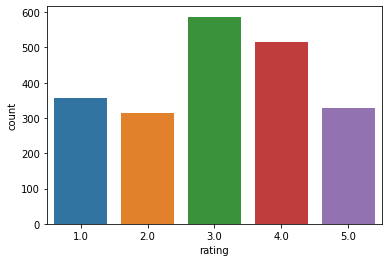

In [ ]:
import seaborn as sns
sns.countplot(df['rating'])

In [ ]:
df.shape

(2100, 4)

In [ ]:
df.isnull().sum()

rating         0
title          1
description    2
job_title      0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum().any()

False

In [ ]:
import nltk
from nltk import corpus
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import string
import re
from nltk.stem import WordNetLemmatizer
clean = re.compile('<.*?>')
ps = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')
lem = WordNetLemmatizer()

def cleanText(text):
    html = re.sub(clean,'',text)
    p_text = ''.join([i.lower() for i in html if i not in string.punctuation])
    token = re.split('\W+',p_text)
    #stop = [ps.stem(i) for i in token if i not in stopwords]
    stop = [lem.lemmatize(i) for i in token if i not in stopwords]
    sent = ' '.join(stop)
    return sent

In [ ]:
df_train = df.copy()

In [ ]:
df_train['refined review'] = df['description'].apply(lambda x : cleanText(x))
df_train.head()

,rating,title,description,job_title,refined review
0,4.0,"Good money, a job not a career",I worked night shift so it;s tough to get accl...,Picker,worked night shift tough get acclimated schedu...
1,1.0,Terrible place to work in and only recommend i...,Working as a warehouse associate for Amazon is...,Warehouse Associate,working warehouse associate amazon one job acc...
2,4.0,It's okay,If your gonna work here work flex other wise t...,Amazon Fulfillment Associate,gonna work work flex wise ot peak suck work fl...
3,3.0,Hard and fast paced work,Donât work here if you are not up for non st...,Warehouse Worker,donâ work non stop working entire shift itâ ha...
4,4.0,I had a great time but YMMV,The teams at amazon have very little to do wit...,SDE Intern,team amazon little get drastically different e...


#### Assigning ratings '1,2,3' -> '0' and '4,5' -> 1

In [ ]:
df_train['output'] = df_train['rating'].apply(lambda x: 1 if x >=4.0 else 0)
df_train.head()

,rating,title,description,job_title,refined review,output
0,4.0,"Good money, a job not a career",I worked night shift so it;s tough to get accl...,Picker,worked night shift tough get acclimated schedu...,1
1,1.0,Terrible place to work in and only recommend i...,Working as a warehouse associate for Amazon is...,Warehouse Associate,working warehouse associate amazon one job acc...,0
2,4.0,It's okay,If your gonna work here work flex other wise t...,Amazon Fulfillment Associate,gonna work work flex wise ot peak suck work fl...,1
3,3.0,Hard and fast paced work,Donât work here if you are not up for non st...,Warehouse Worker,donâ work non stop working entire shift itâ ha...,0
4,4.0,I had a great time but YMMV,The teams at amazon have very little to do wit...,SDE Intern,team amazon little get drastically different e...,1


In [ ]:
df_train.drop(['rating','title','description','job_title'], axis='columns', inplace=True)
df_train.head()

,refined review,output
0,worked night shift tough get acclimated schedu...,1
1,working warehouse associate amazon one job acc...,0
2,gonna work work flex wise ot peak suck work fl...,1
3,donâ work non stop working entire shift itâ ha...,0
4,team amazon little get drastically different e...,1


In [ ]:
X = df_train['refined review']
y = df_train['output']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

In [ ]:
x_train_count = cv.fit_transform(X_train)
x_train_count

<1572x3632 sparse matrix of type '<class 'numpy.int64'>'
	with 35341 stored elements in Compressed Sparse Row format>

In [ ]:
x_test_count = cv.transform(X_test)
x_test_count

<525x3632 sparse matrix of type '<class 'numpy.int64'>'
	with 11145 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdf = TfidfVectorizer()

In [ ]:
x_tfIdf_train = tfIdf.fit_transform(X_train)
x_tfIdf_train

<1572x4491 sparse matrix of type '<class 'numpy.float64'>'
	with 35803 stored elements in Compressed Sparse Row format>

In [ ]:
x_tfIdf_test = tfIdf.transform(X_test)
x_tfIdf_test

<525x4491 sparse matrix of type '<class 'numpy.float64'>'
	with 11119 stored elements in Compressed Sparse Row format>

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
logReg = LogisticRegression()
param = {
        'penalty' : ['l1', 'l2', 'elasticnet'],
        'C' : [100, 10, 1.0, 0.1, 0.01]
        }

gs_lr = GridSearchCV(logReg, param, cv=5)
gs_fit_lr = gs_lr.fit(x_tfIdf_train, y_train)
pd.DataFrame(gs_fit_lr.cv_results_).sort_values('mean_test_score', ascending=False).head()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.039624,0.002783,0.000527,0.000020,10,l2,"{'C': 10, 'penalty': 'l2'}",0.730159,0.730159,0.707006,0.738854,0.735669,0.728369,0.011189,1
7,0.024426,0.001196,0.000525,0.000003,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.733333,0.726984,0.713376,0.713376,0.748408,0.727095,0.013188,2
1,0.079833,0.018394,0.000621,0.000156,100,l2,"{'C': 100, 'penalty': 'l2'}",0.714286,0.720635,0.694268,0.722930,0.703822,0.711188,0.010745,3
10,0.014896,0.002304,0.000523,0.000004,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.660317,0.679365,0.649682,0.627389,0.643312,0.652013,0.017347,4
13,0.010490,0.000506,0.000507,0.000015,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.593651,0.593651,0.595541,0.595541,0.595541,0.594785,0.000926,5


In [ ]:
prediction_lr = gs_fit_lr.predict(x_tfIdf_test)
prediction_lr[0:5]

array([0, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
print('Accuracy of logistic regression is {}'.format(accuracy_score(y_test, prediction_lr)))

Accuracy of logistic regression is 0.7409523809523809


In [ ]:
print('Classification Report of logistic regression : \n\n {}' .format(classification_report(y_test,prediction_lr)))

Classification Report of logistic regression : 

               precision    recall  f1-score   support

           0       0.77      0.82      0.80       324
           1       0.68      0.61      0.64       201

    accuracy                           0.74       525
   macro avg       0.73      0.72      0.72       525
weighted avg       0.74      0.74      0.74       525



## Word2Vec

Training the Word2Vec Model

In [ ]:
df_train.iloc[0,0]

'worked night shift tough get acclimated schedule pay good especially night shift bureaucratic company '

In [ ]:
df_train.iloc[:,0].dtype

dtype('O')

In [ ]:
import gensim
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def word2vec(text):
  model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4
    )
  model.build_vocab(text.apply(lambda x : word_tokenize(x)))
  model.train(text.apply(lambda x : word_tokenize(x)), total_examples=model.corpus_count, epochs= 5)
  return model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
model_w2vec = word2vec(df_train.iloc[:,0])

In [ ]:
model_w2vec.save("Word2Vec.model")

In [ ]:
from google.colab import files
files.download('word2vec.model') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_w2vec.wv.most_similar("amazon")

[('team', 0.9998767375946045),
 ('others', 0.999875009059906),
 ('safety', 0.9998738765716553),
 ('love', 0.9998716115951538),
 ('working', 0.9998692870140076),
 ('made', 0.9998689293861389),
 ('iâ', 0.9998636245727539),
 ('heard', 0.9998635053634644),
 ('way', 0.9998608827590942),
 ('worker', 0.9998583793640137)]

In [ ]:
model_w2vec.wv.similarity(w1="normal", w2="ok")

0.9900376

## Name Entity Recognition Integrated with Word2Vec



In [ ]:
import spacy
from spacy import displacy

def ner(text):
  ner = spacy.load('en_core_web_sm')
  li_ner = []

  for i in range(len(text)):
    doc = ner(text[i])
    li_ner.append([(X.text, X.label_, model_w2vec.wv.most_similar(X.text)[0:3]) for X in doc.ents if X.text in model_w2vec.wv.vocab])

  return li_ner  

In [ ]:
li = ner(list(df_train.iloc[:,0]))
li[0:7]

[[('night',
   'TIME',
   [('tough', 0.9994843006134033),
    ('schedule', 0.9984972476959229),
    ('shift', 0.9984487891197205)]),
  ('night',
   'TIME',
   [('tough', 0.9994843006134033),
    ('schedule', 0.9984972476959229),
    ('shift', 0.9984487891197205)])],
 [],
 [],
 [],
 [],
 [('amazon',
   'ORG',
   [('team', 0.9998767375946045),
    ('others', 0.999875009059906),
    ('safety', 0.9998738765716553)]),
  ('summer',
   'DATE',
   [('bit', 0.9998202919960022),
    ('almost', 0.9998138546943665),
    ('honestly', 0.9998124837875366)])],
 []]

In [ ]:
df_train.head()

,refined review,output
0,worked night shift tough get acclimated schedu...,1
1,working warehouse associate amazon one job acc...,0
2,gonna work work flex wise ot peak suck work fl...,1
3,donâ work non stop working entire shift itâ ha...,0
4,team amazon little get drastically different e...,1


In [ ]:
doc = ner(df_train.iloc[5,0])
print([(X.text, X.label_, model_w2vec.wv.most_similar(X.text)[0:3]) for X in doc.ents])

[('amazon', 'ORG', [('definitely', 0.9998681545257568), ('best', 0.9998160004615784), ('average', 0.9998049139976501)]), ('summer', 'DATE', [('honestly', 0.9998524785041809), ('compensation', 0.9998505115509033), ('almost', 0.9998499155044556)])]


In [ ]:
li[0][1][2][2][0]

'shift'